In [1]:
#Import Librarires
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import seaborn as sns 
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
import math 
%matplotlib inline

In [2]:
#Set working Directory
os.chdir("S:\Aparajita\edwisor\proj2_cab")

In [3]:
#Load csv data
cab_data=pd.read_csv("train_cab.csv")

# Expolatory Data Analysis

In [4]:
cab_data.shape

(16067, 7)

In [5]:
cab_data.head(5)

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1.0
1,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1.0
2,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2.0
3,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1.0
4,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1.0


In [6]:
#Checking the datatypes
cab_data.dtypes

fare_amount           object
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count      float64
dtype: object

In [7]:
#Changing the datatypes
cab_data['fare_amount'] = pd.to_numeric(cab_data['fare_amount'],errors='coerce')
cab_data.pickup_datetime = pd.to_datetime(cab_data.pickup_datetime, errors='coerce')
cab_data['pickup_month']=cab_data['pickup_datetime'].dt.month
cab_data['pickup_day']=cab_data['pickup_datetime'].dt.weekday
cab_data['pickup_hour']=cab_data['pickup_datetime'].dt.hour
cab_data = cab_data.drop(['pickup_datetime'], axis=1)
cab_data['passenger_count']=cab_data['passenger_count'].astype('category')
cab_data['pickup_month']=cab_data['pickup_month'].astype('category')
cab_data['pickup_hour']=cab_data['pickup_hour'].astype('category')
cab_data['pickup_day']=cab_data['pickup_day'].astype('category')

In [8]:
#Checking the datatypes
cab_data.dtypes

fare_amount           float64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
passenger_count      category
pickup_month         category
pickup_day           category
pickup_hour          category
dtype: object

In [9]:
cab_data.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
count,16042.000000,16067.000000,16067.000000,16067.000000,16067.000000
mean,15.015004,-72.462787,39.914725,-72.462328,39.897906
std,430.460945,10.578384,6.826587,10.575062,6.187087
min,-3.000000,-74.438233,-74.006893,-74.429332,-74.006377
25%,6.000000,-73.992156,40.734927,-73.991182,40.734651
50%,8.500000,-73.981698,40.752603,-73.980172,40.753567
75%,12.500000,-73.966838,40.767381,-73.963643,40.768013
max,54343.000000,40.766125,401.083332,40.802437,41.366138


#### Visualizing Categorical Variables

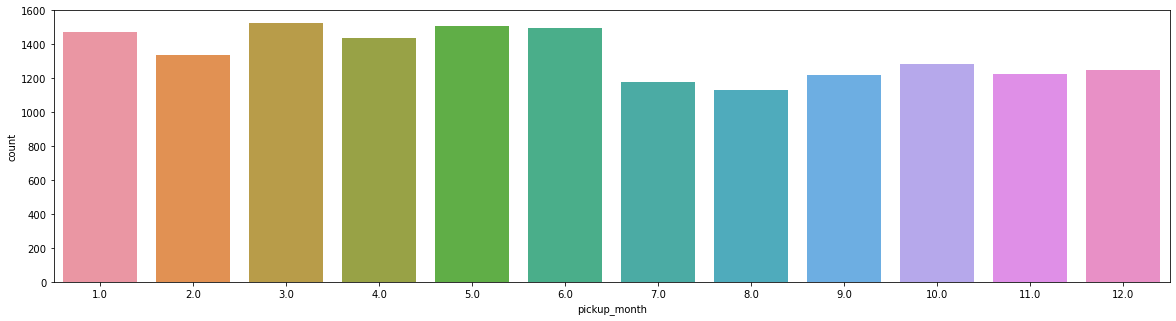

In [10]:
plt.figure(figsize=(20,5))
sns.countplot(x="pickup_month", data=cab_data)

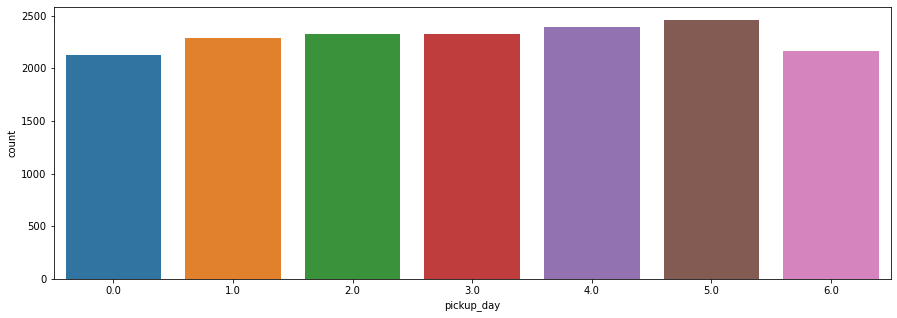

In [11]:
plt.figure(figsize=(15,5))
sns.countplot(x="pickup_day", data=cab_data)

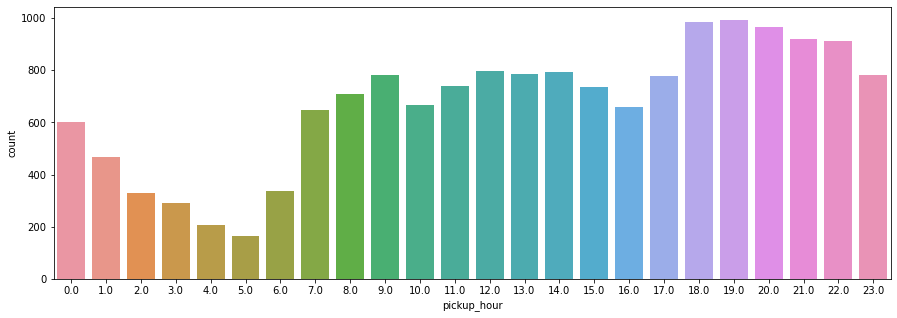

In [12]:
plt.figure(figsize=(15,5))
sns.countplot(x="pickup_hour", data=cab_data)

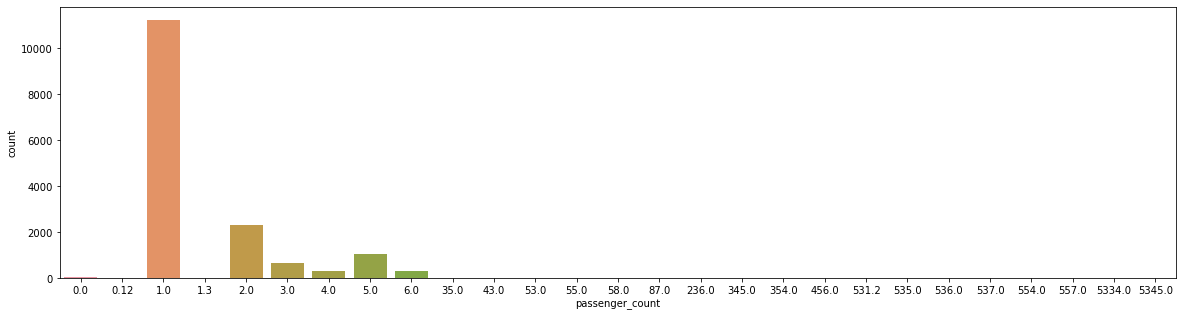

In [13]:
plt.figure(figsize=(20,5))
sns.countplot(x="passenger_count", data=cab_data)

#### Initial cleaning of data

In [14]:
#A CAb can have passsenger values between 1 and 6 and only integer values
lis=[1,2,3,4,5,6]
d1=cab_data['passenger_count'].copy()
for i in range (0,d1.shape[0]):
    if (d1[i] not in lis):
        d1[i]=np.nan
        
cab_data['passenger_count']=d1.astype('category')

In [15]:
#Cab Fare cannot be -ve or 0, replacing it with na
cab_data['fare_amount'] = np.where(cab_data['fare_amount']<=0,np.nan,cab_data['fare_amount'])


In [16]:
#coordinates cant be 0 and latitude cannot be greater 90 thus dropping those observations
cab_data = cab_data[cab_data['pickup_longitude']!=0]
cab_data = cab_data[cab_data['pickup_latitude']!=0]
cab_data = cab_data[cab_data['dropoff_longitude']!=0]
cab_data = cab_data[cab_data['dropoff_latitude']!=0]
cab_data = cab_data[cab_data['pickup_latitude']<=90]

# Missing Value Analysis 

In [17]:

#Create dataframe with missing percentage
missing_val = pd.DataFrame(cab_data.isnull().sum())
missing_val = missing_val.reset_index()
missing_val = missing_val.rename(columns = {'index': 'Variables', 0: 'Missing_percentage'})
missing_val['Missing_percentage'] = (missing_val['Missing_percentage']/len(cab_data))*100
missing_val = missing_val.sort_values('Missing_percentage', ascending = False).reset_index(drop = True)

missing_val

,Variables,Missing_percentage
0,passenger_count,0.825921
1,fare_amount,0.171537
2,pickup_month,0.006353
3,pickup_day,0.006353
4,pickup_hour,0.006353
5,pickup_longitude,0.000000
6,pickup_latitude,0.000000
7,dropoff_longitude,0.000000
8,dropoff_latitude,0.000000


In [18]:
#Dropping observations with NA
cab_data=cab_data.dropna()

In [19]:
#chicking the dimensions of the data frame
cab_data.shape

(15583, 9)

# Outlier Analysis

{'whiskers': [<matplotlib.lines.Line2D at 0x2b69eb76c10>,
 'caps': [<matplotlib.lines.Line2D at 0x2b69eb82310>,
 'boxes': [<matplotlib.lines.Line2D at 0x2b69eb768b0>],
 'medians': [<matplotlib.lines.Line2D at 0x2b69eb829d0>],
 'fliers': [<matplotlib.lines.Line2D at 0x2b69eb82cd0>],
 'means': []}

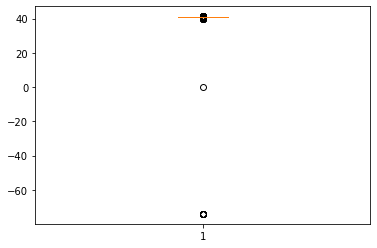

In [20]:
plt.boxplot(cab_data['pickup_latitude'])

{'whiskers': [<matplotlib.lines.Line2D at 0x2b69f189130>,
 'caps': [<matplotlib.lines.Line2D at 0x2b69f1897f0>,
 'boxes': [<matplotlib.lines.Line2D at 0x2b69f17bd90>],
 'medians': [<matplotlib.lines.Line2D at 0x2b69f189eb0>],
 'fliers': [<matplotlib.lines.Line2D at 0x2b69f1941f0>],
 'means': []}

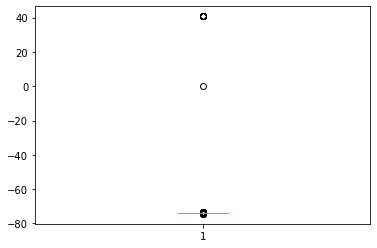

In [21]:
plt.boxplot(cab_data['pickup_longitude'])

{'whiskers': [<matplotlib.lines.Line2D at 0x2b69f1d9b20>,
 'caps': [<matplotlib.lines.Line2D at 0x2b69f1e8220>,
 'boxes': [<matplotlib.lines.Line2D at 0x2b69f1d97c0>],
 'medians': [<matplotlib.lines.Line2D at 0x2b69f1e88e0>],
 'fliers': [<matplotlib.lines.Line2D at 0x2b69f1e8be0>],
 'means': []}

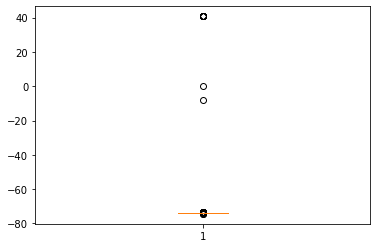

In [22]:
plt.boxplot(cab_data['dropoff_longitude'])

{'whiskers': [<matplotlib.lines.Line2D at 0x2b69f245430>,
 'caps': [<matplotlib.lines.Line2D at 0x2b69f245af0>,
 'boxes': [<matplotlib.lines.Line2D at 0x2b69f2450d0>],
 'medians': [<matplotlib.lines.Line2D at 0x2b69f24f1f0>],
 'fliers': [<matplotlib.lines.Line2D at 0x2b69f24f4f0>],
 'means': []}

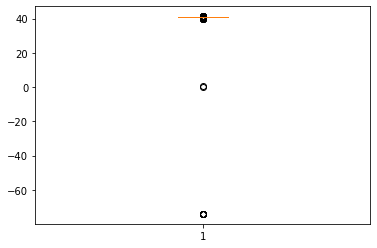

In [23]:
plt.boxplot(cab_data['dropoff_latitude'])

{'whiskers': [<matplotlib.lines.Line2D at 0x2b6a0268130>,
 'caps': [<matplotlib.lines.Line2D at 0x2b6a02687f0>,
 'boxes': [<matplotlib.lines.Line2D at 0x2b6a0258d90>],
 'medians': [<matplotlib.lines.Line2D at 0x2b6a0268eb0>],
 'fliers': [<matplotlib.lines.Line2D at 0x2b6a02721f0>],
 'means': []}

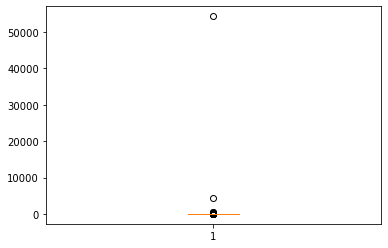

In [24]:
plt.boxplot(cab_data['fare_amount'])

In [25]:
#Detecting outliers and replacing with na
#saving the column names showing outliers
onames=['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude', "fare_amount"]
for i in onames :
    q75,q25=np.percentile(cab_data.loc[:,i],[75,25])
    iqr=q75-q25
    min=q25-(iqr*1.5)
    max=q75+(iqr*1.5)
    cab_data[i] = np.where(cab_data[i]< min,np.nan,cab_data[i])
    cab_data[i] = np.where(cab_data[i]>max,np.nan,cab_data[i])
    


In [26]:
#Dropping outlier observations
cab_data=cab_data.dropna()

# Feature Engineering

In [27]:
#Calculating distance from coordinates
from math import sin, cos, sqrt, atan2, radians,asin
#Calculate the great circle distance between two points on the earth (specified in decimal degrees)
def dist(lon1, lat1, lon2, lat2):
    # Convert latitude and longitude to radians
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    # Find the differences
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    # Apply the formula 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    # Calculate the angle (in radians)
    c = 2 * np.arcsin(np.sqrt(a))
    # Convert to kilometers
    km = 6367 * c
    return km                                          

In [28]:
#Calculating dist on the basis of coordinates
cab_data['Distance_KM'] =  dist(cab_data['pickup_longitude'], cab_data['pickup_latitude'],cab_data['dropoff_longitude'], 
                                cab_data['dropoff_latitude']) 

In [29]:
#observations with Distance equal to zero
sum(cab_data['Distance_KM']==0)

113

In [30]:
#Distance cannot be zero
cab_data = cab_data[cab_data['Distance_KM']!=0]

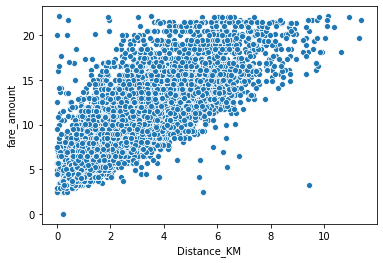

In [31]:
#Visualising  distance vs fare amount
ax = sns.scatterplot(x="Distance_KM", y="fare_amount", data=cab_data)

In [32]:
#Rearraging columns
column_names = ['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude',
                "passenger_count", "pickup_month", "pickup_day", "pickup_hour", "Distance_KM", "fare_amount"]

cab_data = cab_data.reindex(columns=column_names)


In [33]:
#Correcting the datatypes
cab_data['passenger_count']=cab_data['passenger_count'].astype('category')
cab_data['pickup_month']=cab_data['pickup_month'].astype('category')
cab_data['pickup_hour']=cab_data['pickup_hour'].astype('category')
cab_data['pickup_day']=cab_data['pickup_day'].astype('category')

# Correlation analysis

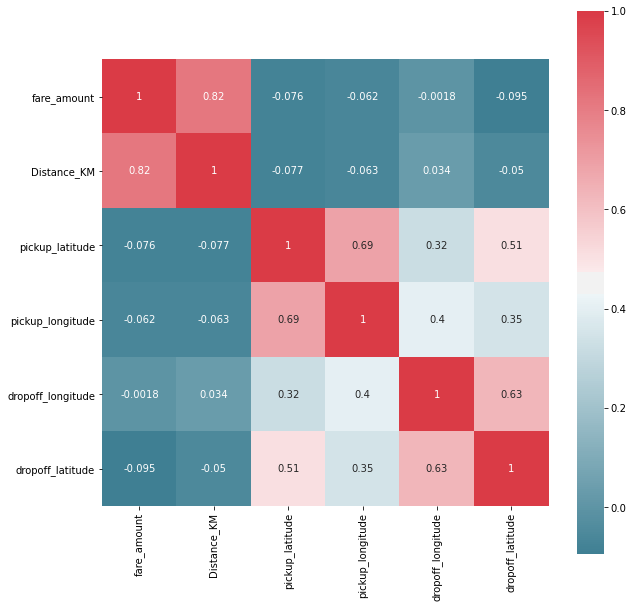

In [34]:

cont_names = ["fare_amount", "Distance_KM",'pickup_latitude','pickup_longitude','dropoff_longitude','dropoff_latitude']
#Correlation plot
df_corr = cab_data.loc[:,cont_names]
#Set the width and hieght of the plot
f, ax = plt.subplots(figsize=(10, 10))
#Generate correlation matrix
corr = df_corr.corr()
#Plot using seaborn library
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True), 
            annot = True , square=True, ax=ax)


# Simple Random Sampling

In [35]:
Sample_Index = np.random.rand(len(cab_data)) < 0.8

train_1 = cab_data[Sample_Index]
test_1 = cab_data[~Sample_Index]

# Linear Regression Model

### Normality check

(array([ 85.,  91., 206., 425., 576., 782., 742., 861., 785., 747., 616.,
        694., 567., 538., 461., 496., 414., 384., 349., 313., 277., 248.,
        250., 207., 173., 182., 150., 176., 124., 135., 112., 120., 102.,
         84.,  75.,  78.,  64.,  71.,  63.,  51.,  54.,  51.,  31.,  28.,
         29.,  26.,  21.,  18.,  13.,   9.,  12.,  10.,  11.,   7.,   9.,
          6.,   0.,   3.,   8.,   3.,   5.,   3.,   3.,   1.,   1.,   0.,
          1.,   0.,   1.,   0.,   2.]),
 array([2.01741714e-04, 1.60849794e-01, 3.21497846e-01, 4.82145898e-01,
        6.42793950e-01, 8.03442002e-01, 9.64090054e-01, 1.12473811e+00,
        1.28538616e+00, 1.44603421e+00, 1.60668226e+00, 1.76733031e+00,
        1.92797837e+00, 2.08862642e+00, 2.24927447e+00, 2.40992252e+00,
        2.57057057e+00, 2.73121863e+00, 2.89186668e+00, 3.05251473e+00,
        3.21316278e+00, 3.37381083e+00, 3.53445889e+00, 3.69510694e+00,
        3.85575499e+00, 4.01640304e+00, 4.17705109e+00, 4.33769915e+00,
        4.49

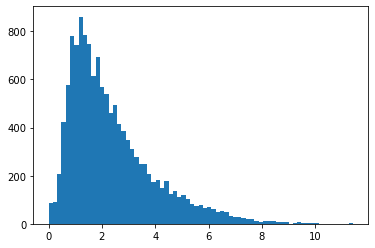

In [36]:
plt.hist(cab_data['Distance_KM'], bins='auto')

(array([ 33.,  86.,  47.,  53., 122., 261., 335., 342., 300., 265., 277.,
        323., 375., 466., 628., 553., 625., 562., 561., 696., 670., 503.,
        570., 436., 427., 390., 322., 309., 288., 261., 227., 267., 254.,
        205., 271., 284., 200., 144.,  94.,  73.,  60.,  15.,   7.,  18.,
         17.,   9.,   3.,   6.]),
 array([-74.018108  , -74.01630965, -74.01451129, -74.01271294,
        -74.01091458, -74.00911623, -74.00731787, -74.00551952,
        -74.00372117, -74.00192281, -74.00012446, -73.9983261 ,
        -73.99652775, -73.9947294 , -73.99293104, -73.99113269,
        -73.98933433, -73.98753598, -73.98573762, -73.98393927,
        -73.98214092, -73.98034256, -73.97854421, -73.97674585,
        -73.9749475 , -73.97314915, -73.97135079, -73.96955244,
        -73.96775408, -73.96595573, -73.96415737, -73.96235902,
        -73.96056067, -73.95876231, -73.95696396, -73.9551656 ,
        -73.95336725, -73.9515689 , -73.94977054, -73.94797219,
        -73.94617383, -73.9443

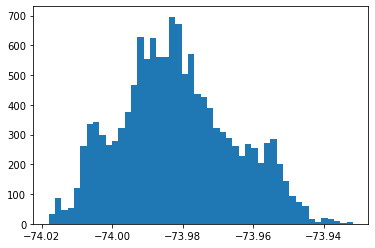

In [37]:
plt.hist(cab_data['pickup_longitude'], bins='auto')

(array([ 20.,  15.,   5.,   4.,   4.,  47.,  74.,  88.,  86.,  87., 149.,
        160., 255., 272., 311., 279., 308., 340., 373., 336., 438., 525.,
        483., 419., 518., 703., 490., 604., 593., 637., 685., 552., 420.,
        381., 338., 327., 319., 357., 261., 178., 168., 138.,  87., 102.,
         59.,  58.,  36.,  37.,  52.,  35.,  17.,  10.]),
 array([40.689736  , 40.69213581, 40.69453562, 40.69693542, 40.69933523,
        40.70173504, 40.70413485, 40.70653465, 40.70893446, 40.71133427,
        40.71373408, 40.71613388, 40.71853369, 40.7209335 , 40.72333331,
        40.72573312, 40.72813292, 40.73053273, 40.73293254, 40.73533235,
        40.73773215, 40.74013196, 40.74253177, 40.74493158, 40.74733138,
        40.74973119, 40.752131  , 40.75453081, 40.75693062, 40.75933042,
        40.76173023, 40.76413004, 40.76652985, 40.76892965, 40.77132946,
        40.77372927, 40.77612908, 40.77852888, 40.78092869, 40.7833285 ,
        40.78572831, 40.78812812, 40.79052792, 40.79292773, 40

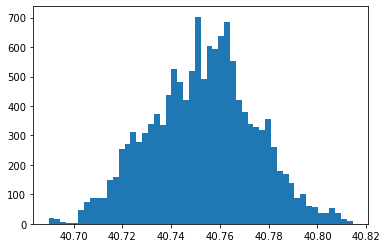

In [38]:
plt.hist(cab_data['pickup_latitude'], bins='auto')

(array([  8.,  44.,  68.,  80., 102., 165., 247., 328., 275., 283., 269.,
        258., 301., 363., 446., 633., 637., 569., 547., 523., 718., 601.,
        629., 523., 505., 455., 359., 293., 281., 254., 222., 278., 239.,
        230., 253., 283., 257., 157., 127., 123.,  76.,  53.,  38.,  33.,
         32.,  18.,  14.,  16.,   5.,  14.,   8.]),
 array([-74.019535  , -74.01771376, -74.01589253, -74.01407129,
        -74.01225006, -74.01042882, -74.00860759, -74.00678635,
        -74.00496512, -74.00314388, -74.00132265, -73.99950141,
        -73.99768018, -73.99585894, -73.99403771, -73.99221647,
        -73.99039524, -73.988574  , -73.98675276, -73.98493153,
        -73.98311029, -73.98128906, -73.97946782, -73.97764659,
        -73.97582535, -73.97400412, -73.97218288, -73.97036165,
        -73.96854041, -73.96671918, -73.96489794, -73.96307671,
        -73.96125547, -73.95943424, -73.957613  , -73.95579176,
        -73.95397053, -73.95214929, -73.95032806, -73.94850682,
        -73.

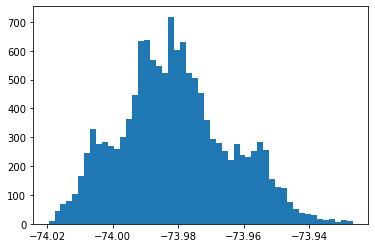

In [39]:
#Normality check
%matplotlib inline  
plt.hist(cab_data['dropoff_longitude'], bins='auto')

(array([ 28.,  27.,  31.,  23.,  16.,  44.,  75., 104., 110.,  95., 124.,
        166., 183., 228., 290., 291., 266., 295., 301., 323., 360., 484.,
        410., 446., 403., 711., 585., 547., 632., 713., 697., 604., 401.,
        358., 350., 355., 324., 331., 273., 245., 179., 165., 118.,  93.,
         78.,  59.,  64.,  53.,  67.,  48.,  37.,  14.,  16.]),
 array([40.688335  , 40.69074894, 40.69316289, 40.69557683, 40.69799077,
        40.70040472, 40.70281866, 40.7052326 , 40.70764655, 40.71006049,
        40.71247443, 40.71488838, 40.71730232, 40.71971626, 40.72213021,
        40.72454415, 40.72695809, 40.72937204, 40.73178598, 40.73419992,
        40.73661387, 40.73902781, 40.74144175, 40.7438557 , 40.74626964,
        40.74868358, 40.75109753, 40.75351147, 40.75592542, 40.75833936,
        40.7607533 , 40.76316725, 40.76558119, 40.76799513, 40.77040908,
        40.77282302, 40.77523696, 40.77765091, 40.78006485, 40.78247879,
        40.78489274, 40.78730668, 40.78972062, 40.792134

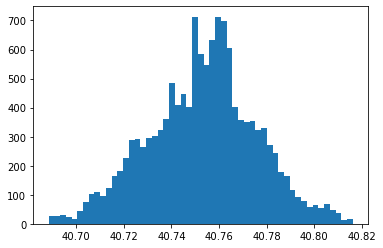

In [40]:
plt.hist(cab_data['dropoff_latitude'], bins='auto')

In [41]:
#Create linear regression data.
onames=['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude',"Distance_KM"]
cab_data_temp = pd.DataFrame(cab_data[onames])

##Create dummies for categorical variables
cat_names = ['passenger_count','pickup_month','pickup_day','pickup_hour']

for i in cat_names:
    temp = pd.get_dummies(cab_data[i], prefix = i)
    cab_data_temp = cab_data_temp.join(temp)
cab_data_temp=cab_data_temp.join(cab_data['fare_amount'])

#normalisation
for i in onames :
    cab_data_temp[i] = (cab_data_temp[i] - cab_data_temp[i].min())/ (cab_data_temp[i].max() - cab_data_temp[i].min())
    
#Checking the data for linear regression
cab_data_temp

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,Distance_KM,passenger_count_0.0,passenger_count_0.12,passenger_count_1.0,passenger_count_1.3,passenger_count_2.0,...,pickup_hour_15.0,pickup_hour_16.0,pickup_hour_17.0,pickup_hour_18.0,pickup_hour_19.0,pickup_hour_20.0,pickup_hour_21.0,pickup_hour_22.0,pickup_hour_23.0,fare_amount
1,0.023864,0.172826,0.433524,0.732138,0.740366,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,16.9
2,0.409750,0.573235,0.304609,0.486380,0.121730,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,5.7
3,0.358870,0.347840,0.301110,0.545236,0.245249,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,7.7
4,0.579384,0.627230,0.676981,0.745879,0.175144,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,5.3
5,0.198608,0.335716,0.502169,0.546338,0.331813,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,12.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16061,0.277070,0.492043,0.611156,0.636116,0.294159,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,10.9
16062,0.107598,0.232559,0.222538,0.247399,0.074462,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,6.5
16063,0.426293,0.736910,0.055371,0.212539,0.689329,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,16.1
16064,0.528272,0.510305,0.430197,0.603100,0.128702,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,8.5


In [42]:
#Test and Train data for multiple Linear Regression
train_lr = cab_data_temp[Sample_Index]
test_lr = cab_data_temp[~Sample_Index]

In [43]:
train_lr

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,Distance_KM,passenger_count_0.0,passenger_count_0.12,passenger_count_1.0,passenger_count_1.3,passenger_count_2.0,...,pickup_hour_15.0,pickup_hour_16.0,pickup_hour_17.0,pickup_hour_18.0,pickup_hour_19.0,pickup_hour_20.0,pickup_hour_21.0,pickup_hour_22.0,pickup_hour_23.0,fare_amount
3,0.358870,0.347840,0.301110,0.545236,0.245249,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,7.7
4,0.579384,0.627230,0.676981,0.745879,0.175144,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,5.3
5,0.198608,0.335716,0.502169,0.546338,0.331813,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,12.1
7,0.773948,0.676352,0.316958,0.490179,0.364074,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,16.5
9,0.433846,0.353690,0.301401,0.545596,0.249661,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,8.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16061,0.277070,0.492043,0.611156,0.636116,0.294159,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,10.9
16062,0.107598,0.232559,0.222538,0.247399,0.074462,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,6.5
16063,0.426293,0.736910,0.055371,0.212539,0.689329,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,16.1
16064,0.528272,0.510305,0.430197,0.603100,0.128702,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,8.5


In [44]:
# Building model on top of training dataset
LRmodel = LinearRegression().fit(train_lr.iloc[:,0:75], train_lr.iloc[:,75])
#prediction on train data
LR_predictions = LRmodel.predict(test_lr.iloc[:,0:75])
#Printing the coefficients
coeff_df = pd.DataFrame(LRmodel.coef_, train_lr.iloc[:,0:75].columns, columns=['Coefficient'])  
print(coeff_df)

                    Coefficient
pickup_longitude  -1.239847e-01
pickup_latitude    2.468364e-01
dropoff_longitude  5.453021e-01
dropoff_latitude  -1.930075e+00
Distance_KM        2.289902e+01
...                         ...
pickup_hour_19.0  -5.027085e+12
pickup_hour_20.0  -5.027085e+12
pickup_hour_21.0  -5.027085e+12
pickup_hour_22.0  -5.027085e+12
pickup_hour_23.0  -5.027085e+12

[75 rows x 1 columns]


In [45]:
#Calculating R-squared and adjusted R squared
r_sq = LRmodel.score(train_lr.iloc[:,0:75], train_lr.iloc[:,75])
sam_size = len(train_lr)
predictors=75
a=1-(((1-r_sq)*(sam_size-1))/(sam_size-predictors-1))
print("R-squared:",r_sq)
print("Adjusted R-squared:",a)

R-squared: 0.6934858599889403
Adjusted R-squared: 0.691293341104741


# Decision Tree

In [46]:
#Decision Tree
DTmodel = DecisionTreeRegressor(max_depth=2).fit(train_1.iloc[:,0:9], train_1.iloc[:,9])
DT_predictions = DTmodel.predict(test_1.iloc[:,0:9])

# Random Forest

In [47]:
#Random forest
RFmodel = RandomForestRegressor(n_estimators = 200).fit(train_1.iloc[:,0:9], train_1.iloc[:,9])
RF_Predictions = RFmodel.predict(test_1.iloc[:,0:9])

# Gradient Boosting

In [48]:
cab_data_GB=cab_data

cab_data_GB['passenger_count']=cab_data_GB['passenger_count'].astype('int')
cab_data_GB['pickup_month']=cab_data_GB['pickup_month'].astype('int')
cab_data_GB['pickup_hour']=cab_data_GB['pickup_hour'].astype('int')
cab_data_GB['pickup_day']=cab_data_GB['pickup_day'].astype('int')
train_GB = cab_data[Sample_Index]
test_GB = cab_data[~Sample_Index]


GBModel = XGBRegressor().fit(train_GB.iloc[:,0:9], train_GB.iloc[:,9])
GB_Predictions = GBModel.predict(test_GB.iloc[:,0:9])


In [49]:
#Calculate RMSE


def RMSE(y_true, y_pred): 
    rmse = np.sqrt(mean_squared_error(y_true,y_pred))
    return rmse

#Calculate RMSE for LR
print("RMSE of Multiple Linear Regression=",RMSE(test_lr.iloc[:,75], LR_predictions))

#Calculate RMSE for DT
print("RMSE of Decission Tree=",RMSE(test_1.iloc[:,9], DT_predictions))

#Calculate RMSE for RF
print("RMSE of Random Forest=",RMSE(test_1.iloc[:,9], RF_Predictions))

#Calculate RMSE for GB
print("RMSE of Gradient Boosting=",RMSE(test_1.iloc[:,9], GB_Predictions))



RMSE of Multiple Linear Regression= 2.138040497135078
RMSE of Decission Tree= 2.3361752540093557
RMSE of Random Forest= 2.068920366401793
RMSE of Gradient Boosting= 2.058325509711939


In [50]:
#Calculate MAPE
def MAPE(y_true, y_pred): 
    mape = np.mean(np.abs((y_true - y_pred) / y_true))*100
    return mape

#Calculate MAPE for LR
print("MAPE of Multiple Linear Regression=",MAPE(test_lr.iloc[:,75], LR_predictions),"%")

#Calculate MAPE for DT
print("MAPE of Decission Tree=",MAPE(test_1.iloc[:,9], DT_predictions),"%")

#Calculate MAPE for RF
print("MAPE of Random Forest=",MAPE(test_1.iloc[:,9], RF_Predictions),"%")


#Calculate MAPE for GB
print("MAPE of Gradient Boosting=",MAPE(test_1.iloc[:,9], GB_Predictions),"%")




MAPE of Multiple Linear Regression= 19.04744981494062 %
MAPE of Decission Tree= 21.98300206836533 %
MAPE of Random Forest= 18.640213281346256 %
MAPE of Gradient Boosting= 17.936730188980263 %


In [51]:
#selecting Gradient Boosting, building the model on the complete train data
cab_data['passenger_count']=cab_data['passenger_count'].astype('int')
cab_data['pickup_month']=cab_data['pickup_month'].astype('int')
cab_data['pickup_hour']=cab_data['pickup_hour'].astype('int')
cab_data['pickup_day']=cab_data['pickup_day'].astype('int')
GBModel_Final = XGBRegressor().fit(cab_data.iloc[:,0:9], cab_data.iloc[:,9])

# loading and formatting test data before applying to the model

In [52]:
test=pd.read_csv("test.csv")
df=test.copy()

In [53]:
test.pickup_datetime = pd.to_datetime(test.pickup_datetime, errors='coerce')
test['pickup_month']=test['pickup_datetime'].dt.month
test['pickup_day']=test['pickup_datetime'].dt.weekday
test['pickup_hour']=test['pickup_datetime'].dt.hour
test = test.drop(['pickup_datetime'], axis=1)
test['passenger_count']=test['passenger_count'].astype('int')
test['pickup_month']=test['pickup_month'].astype('int')
test['pickup_hour']=test['pickup_hour'].astype('int')
test['pickup_day']=test['pickup_day'].astype('int')
test['Distance_KM'] =  dist(test['pickup_longitude'], test['pickup_latitude'],test['dropoff_longitude'], 
                            test['dropoff_latitude']) 

In [54]:

column_names = ['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude',
                "passenger_count", "pickup_month", "pickup_day", "pickup_hour", "Distance_KM"]

test = test.reindex(columns=column_names)

In [55]:
#applying the Gradient Boosting Model on test data and saving its output
GB_FPredictions = GBModel_Final.predict(test.iloc[:,0:9])
result=pd.DataFrame(df)
result['Pred_Fare'] = (GB_FPredictions)

result.to_csv("GB_op_python.csv",index=False)